# 李沐 《动手学深度学习》学习笔记(二) 第二章 线性回归 第二节 线性回归的从零开始实现

本节内容：
* 数据流水线
* 模型
* 损失函数
* 小批量随机梯度下降优化器

目的：了解更细致的工作原理将方便我们自定义模型、自定义层或自定义损失函数。

这一节中，我们将只使用张量和自动求导。

In [1]:
# 作用：当调用matplotlib.pyplot的绘图函数plot()进行绘图的时候
# 或者生成一个figure画布的时候，可以直接在python console控制台是里面生成图像。
%matplotlib inline
import random
import torch
from d2l import torch as d2l

## 2.1 生成数据集
合成数据集：  根据带有噪声的线性模型构造而成
* 该数据集包含 1000 个样本
* 每个样本包含从标准正态分布中采样的2个特征
线性模式：
* 线性模型参数**w** = $[2, -3.4]^{T}$，b = 4.2 和 噪声
* 标签： **y** = **Xw** + b + 噪声(噪声服从均值为0的正态分布，标准差为0.01)
* 噪声视为捕获特征和标签时的潜在观测误差

In [2]:
def synthetic_data(w, b, num_examples):
    """生成 y = Xw + b + 噪声"""
#     生成形状为(1000, 2)的正态矩阵
    X = torch.normal(0, 1, (num_examples, len(w)))
#     print(X.shape)
#     torch.matmul()是tensor的乘法
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
#     print(y.shape)
    return X, y.reshape((-1, 1))

In [3]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
# features中的每一行都包含一个二维数据样本
# labels中的每一行都包含一维标签值（一个标量）
features, labels = synthetic_data(true_w, true_b, 1000)

print('features:', features[0], 'labels：', labels[0])

features: tensor([-0.1690, -0.1428]) labels： tensor([4.3534])


通过生成第二个特征 features[:,1] 和 labels 的散点图，可以直观观察到两者之间的线性关系

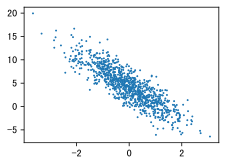

In [4]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)

## 2.2 读取数据集
训练模型时，需要对数据集进行遍历：
* 每次抽一小批量样本，进行训练
* 并使用它们来更新模型

定义一个函数，实现能打乱数据集中的样本，并以小批量方式获取数据
features, labels本质上来看就是列表，所以为了实现数据的随机读取，只需要将读取列表时的标号打乱即可，同时保证完成对所有数据的读取。indices中的数据为0到num_examples - 1中的自然数顺序排列，利用random.shuffle()实现对indices进行随机打乱。使用for循环完成对indices的切割，达到每次输出batch_size样本数的目的。并且该函数使用`生成器`，在每次调用时读取batch_size的数据，而不是一次性全部输出

In [5]:
# 定义一个data_iter函数
# 输入： 批量大小、特征矩阵、标签向量
# 输出： 大小为batch_size的小批量，每个小批量包含一组特征和标签
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples)) 
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    # print(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        # print(batch_indices)
        # 生成器
        yield features[batch_indices], labels[batch_indices]

通常，使用合理大小的小批量来利用GPU硬件的优势，因为GPU在并行处理方面表现出色。每个样本都可以并行地进行模型计算，且每个样本损失函数的梯度也可以并行地计算

读取第一个小批量数据样本并打印。每个批量的特征维度说明了批量大小和输入特征数。同样，批量的标签形状与batch_size相等

In [6]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.6115,  0.8051],
        [ 1.1721, -0.9294],
        [ 0.2071, -0.5420],
        [-1.6199,  0.5070],
        [ 0.7983,  0.6613],
        [-1.7620,  1.6439],
        [ 1.3133, -0.4753],
        [-1.8064, -0.1070],
        [-1.9263, -0.4198],
        [ 0.0122,  0.5488]]) 
 tensor([[ 0.2338],
        [ 9.7141],
        [ 6.4659],
        [-0.7602],
        [ 3.5537],
        [-4.9110],
        [ 8.4553],
        [ 0.9416],
        [ 1.7667],
        [ 2.3317]])


## 2.3 初始化模型参数
在开始使用小批量随机梯度下降优化模型参数，需要初始化一些参数。通过服从均值为0，标准差为0.01的正态分布中采样随机数来初始化权重w，并将偏置b初始化为0

In [7]:
# 需要进行梯度计算，因此requires_grad=True
# w = torch.tensor([0.0, 0], requires_grad=True)
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

## 2.4 定义模型
将模型的输入和参数同模型的输出关联起来。这里定义模型为线性模型，计算线性模型的输出，只需计算输入特征**X**和模型权重**w**的矩阵-向量乘法后加偏置b。

**注意**：**Xw**是一个向量，而b是一个标量，根据广播机制，用一个向量加一个标量时，标量会被加到向量的每个分量上。

In [8]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

## 2.5 定义损失函数
由于更新模型时，需要计算损失函数的梯度。
* 首先确定损失函数，这里选取**平方损失函数**
* 确保真实值y的形状和预测值y_hat的形状相同，就需要将真实值y的形状转换为和预测值y_hat的形状相同

In [9]:
def squared_loss(y_hat, y):
    """均方损失MSE"""
    return (y - y_hat) ** 2 / 2

## 2.6 定义优化算法
由于在深度学习中，深度模型一般都没有解析解，可以根据参数计算损失的梯度来优化算法。

**梯度函数的实现**：小批量随机梯度下降更新
* 输入： 模型参数集合、学习速率和批量大小
* 更新步长：由学习速率lr所决定
* 计算的损失是一个批量样本的总和，所以用批量大小来归一化步长，这样步长大小就不会取决于对批量大小的选择。

In [10]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## 2.7 训练
在每次迭代中，读取一小批量训练样本，并通过模型获取一组预测。计算完损失后，开始向后传播，存储每个参数的梯度，最后调用优化算法sgd来更新模型参数
* 设置超参数：需要通过反复实验进行调整，**迭代周期num_epochs**和**学习率lr**

In [11]:
lr = 0.03
num_epochs = 3
net = linreg   # 模型
loss = squared_loss  # 损失函数

In [12]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # 计算小批量的损失
        # 因为 l 的形状为(batch_size, 1),而不是一个标量。
        # 需要将 l 中所有元素加到一起，并以此计算关于[w, b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size) # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 8.120979
epoch 2, loss 7.983474
epoch 3, loss 8.134356


In [13]:
print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b - b}')

w的估计误差：tensor([ 1.8953, -3.1324], grad_fn=<SubBackward0>)
b的估计误差：tensor([-0.7216], grad_fn=<RsubBackward1>)
